# Analisi sui dati "Boston Housing"

## Introduzione ai dati
Il dataset "Boston Housing" del 1970 è un dataset classico nel campo dell'apprendimento automatico e dell'econometria.\
È stato introdotto per la prima volta nel 1978 da Harrison e Rubinfeld nel loro articolo "Hedonic Prices and the Demand for Clean Air" (Prezzi hedonici e domanda per l'aria pulita).  

Il dataset contiene informazioni su 506 abitazioni della Boston Standard Metropolitan Statistical Area, Massachusetts, negli Stati Uniti.\
È stato creato per esaminare la relazione tra il valore mediano delle abitazioni e una serie di variabili descrittive, tra cui:

1. `crim`: tasso di criminalità per persona in un quartiere.
2. `zn`: proporzione di terreno residenziale assegnato per lotti di oltre 25.000 piedi quadrati (circa 2323 metri quadrati).
3. `indus`: proporzione di ettari dedicati alle attività commerciali non al dettaglio per città.
4. `chas`: variabile binaria che indica se la proprietà si affaccia sul fiume Charles (1 se è vero, 0 altrimenti).
5. `nox`: concentrazione di ossidi di azoto (parti per 10 milioni).
6. `rm`: numero medio di stanze per abitazione.
7. `age`: proporzione di unità occupate dal proprietario costruite prima del 1940.
8. `dis`: distanze ponderate dai cinque centri di impiego di Boston.
9. `rad`: indice di accessibilità alle strade principali.
10. `tax`: tasso di imposta sulla proprietà a valore pieno per 10.000 dollari.
11. `ptratio`: rapporto studenti-insegnanti per quartiere.
12. `lstat`: percentuale di persone a basso reddito.

La variabile che prenderemo come risposta in questa applicazione è il valore mediano delle abitazioni (`medv`), espresso in migliaia di dollari.\
Questo valore rappresenta il valore medio (mediano) delle case occupate dai proprietari nello specifico distretto censuario.\

## Analisi Esplorativa

In [3]:
# importazione delle librarie necessarie
from src.AutoEnsemble import AutoEnsemble
from src.AutoTree import AutoTree
from src.utils import *
# parametri grafici per aumentare la risoluzione di stampa
# de- commentare se si vogliono ottenere i grafici proposti nell'analisi
#plt.rcParams['figure.dpi'] = 300
#sns.set(rc={'figure.dpi': 300})

In [4]:
# lettura dei dati da csv
dati = read_data("Boston.csv",
                 verbose = True)

##################################################
############ READING FILE: Boston.csv ############
################################################## 


N. Observation:  506
N. Variables:  13 

Info about DATASET: 
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB

N. missing va

La funzione ci segnala l'assenza di valori mancanti nel dataset e che tutte le variabili sono di tipo numerico.



########################################################
############# EDA #############
########################################################


FEATURES SUMMARY:
----------------------------------------------------------------------------------------------------
             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

 

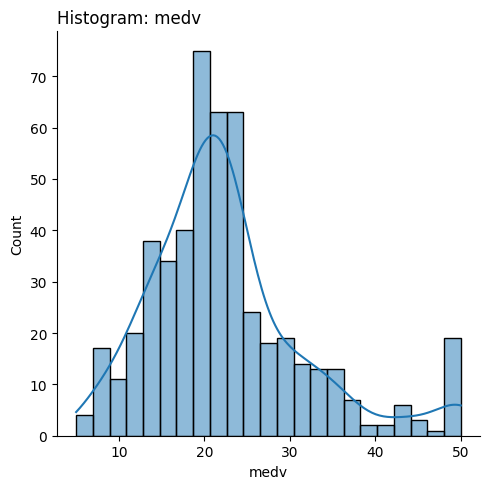

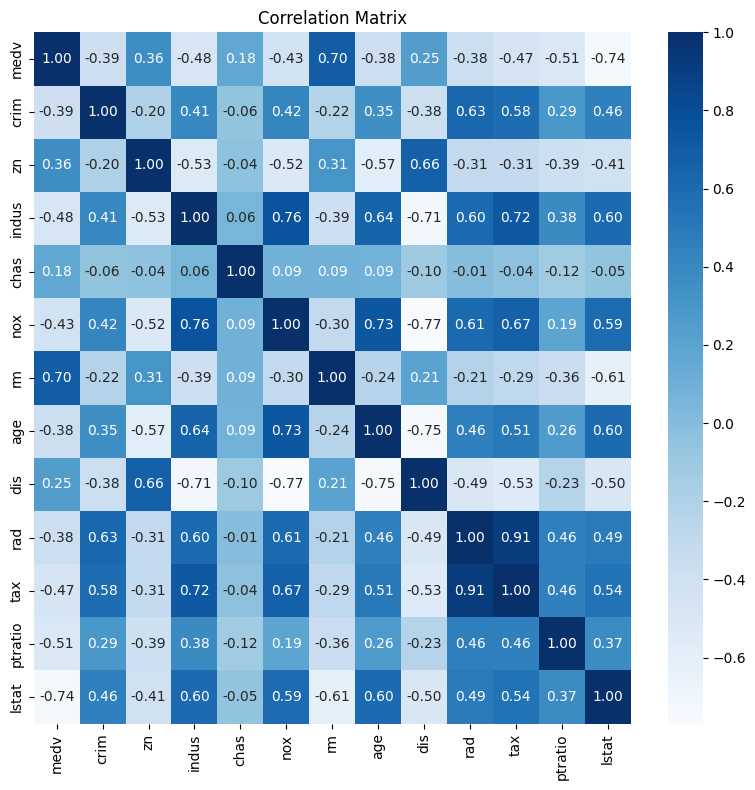

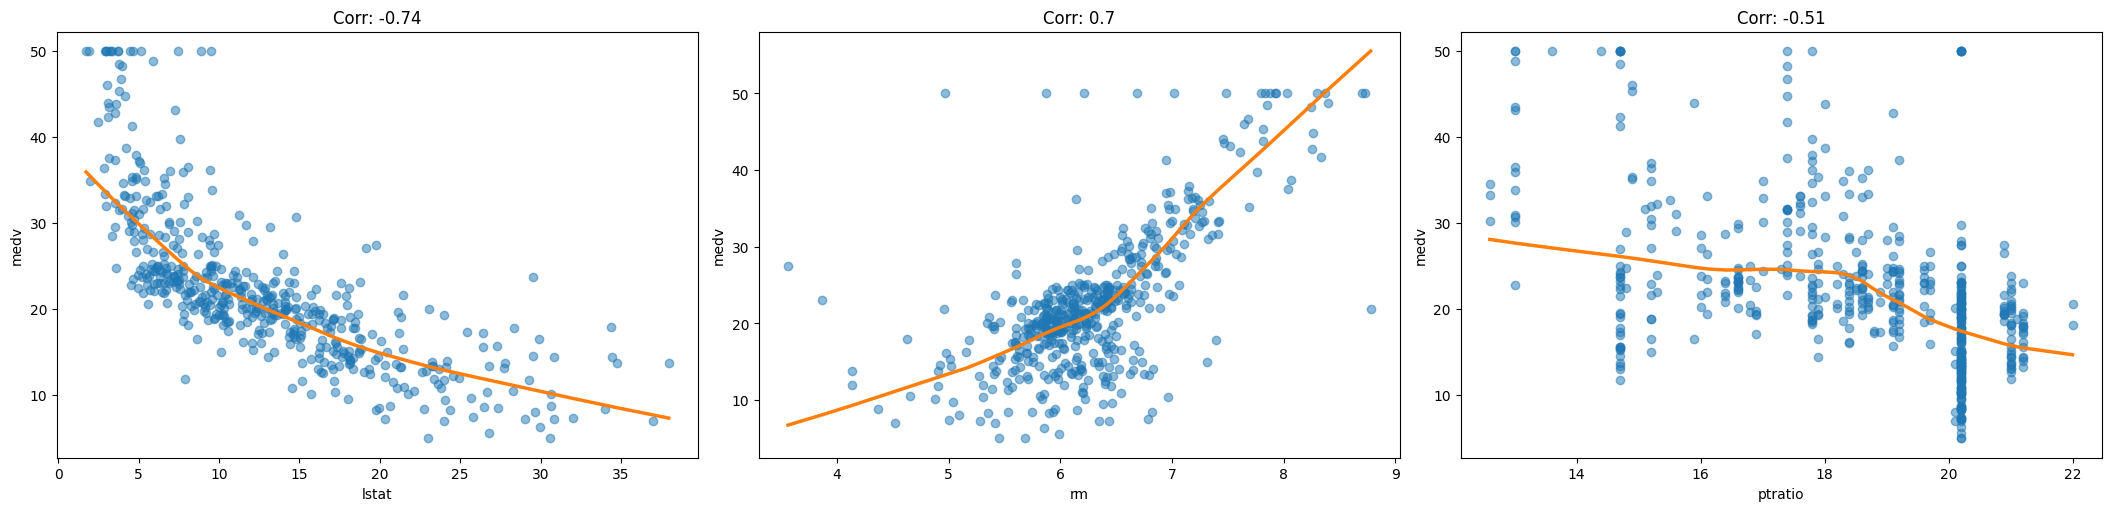

In [5]:
# analisi esplorativa dei dati
auto_eda(dati,
         'medv',
         print_corr=False,
         plot_density=True,
         cor_plot=True,
         threshold=0.5,
         pair_plot=True)

## Adattamento di un modello di regressione ad albero

In [6]:
# Selezione della variabilerisposta
y = dati['medv']
# Creazione matrice del modello
X = model_matrix(dati,
                 'medv',
                 intercept=False,
                 dummies=False,
                 verbose = True)


Covariates in the model matrix: 
----------------------------------------
['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat'] 



In [7]:
# definizione di un oggetto della classe AutoTree come albero di regressione
reg = AutoTree('regressione')
# diagnostica sull'albero inizializzato
print(reg)

##### Albero di Regressione creato con successo! #####

Tree of Regressione,                
> Leaf impurity criterion used: SQUARED_ERROR.                
> Maximum depth: 5.                    
> Min. number of samples required to split an internal node: 2.                    
> Min. number of samples required to be at a leaf node: 5.                        
> Seed used by the random number generator: 0.                        
> Max. number of leaves: None.                            
> A node will be split if this split induces a decrease of impurity greater than or equal to: 0.002.                            
> Complexity parameter used for pruning: 0.0 


In [8]:
# Divisione del dataset in insieme di stima ed insieme di verifica
X_train, X_test, y_train, y_test = split_data(X, y,
                                              size = 0.25)


Splitting data:
----------------------------------------
> N. observation (Train-set):  379
> N. observation (Test-set):  127



FIT STATS:
---------------------------------
> Tree depth: 5
> Number of terminal nodes (leaves): 22
Time taken for fitting: 0.004 s

FEATURE IMPORTANCE:
----------------------------------
Feature lstat: Importance score = 0.654
Feature rm: Importance score = 0.254
Feature age: Importance score = 0.026
Feature ptratio: Importance score = 0.024
Feature crim: Importance score = 0.024
Feature nox: Importance score = 0.010
Feature indus: Importance score = 0.008
Feature dis: Importance score = 0.001
Feature zn: Importance score = 0.000
Feature chas: Importance score = 0.000
Feature rad: Importance score = 0.000
Feature tax: Importance score = 0.000


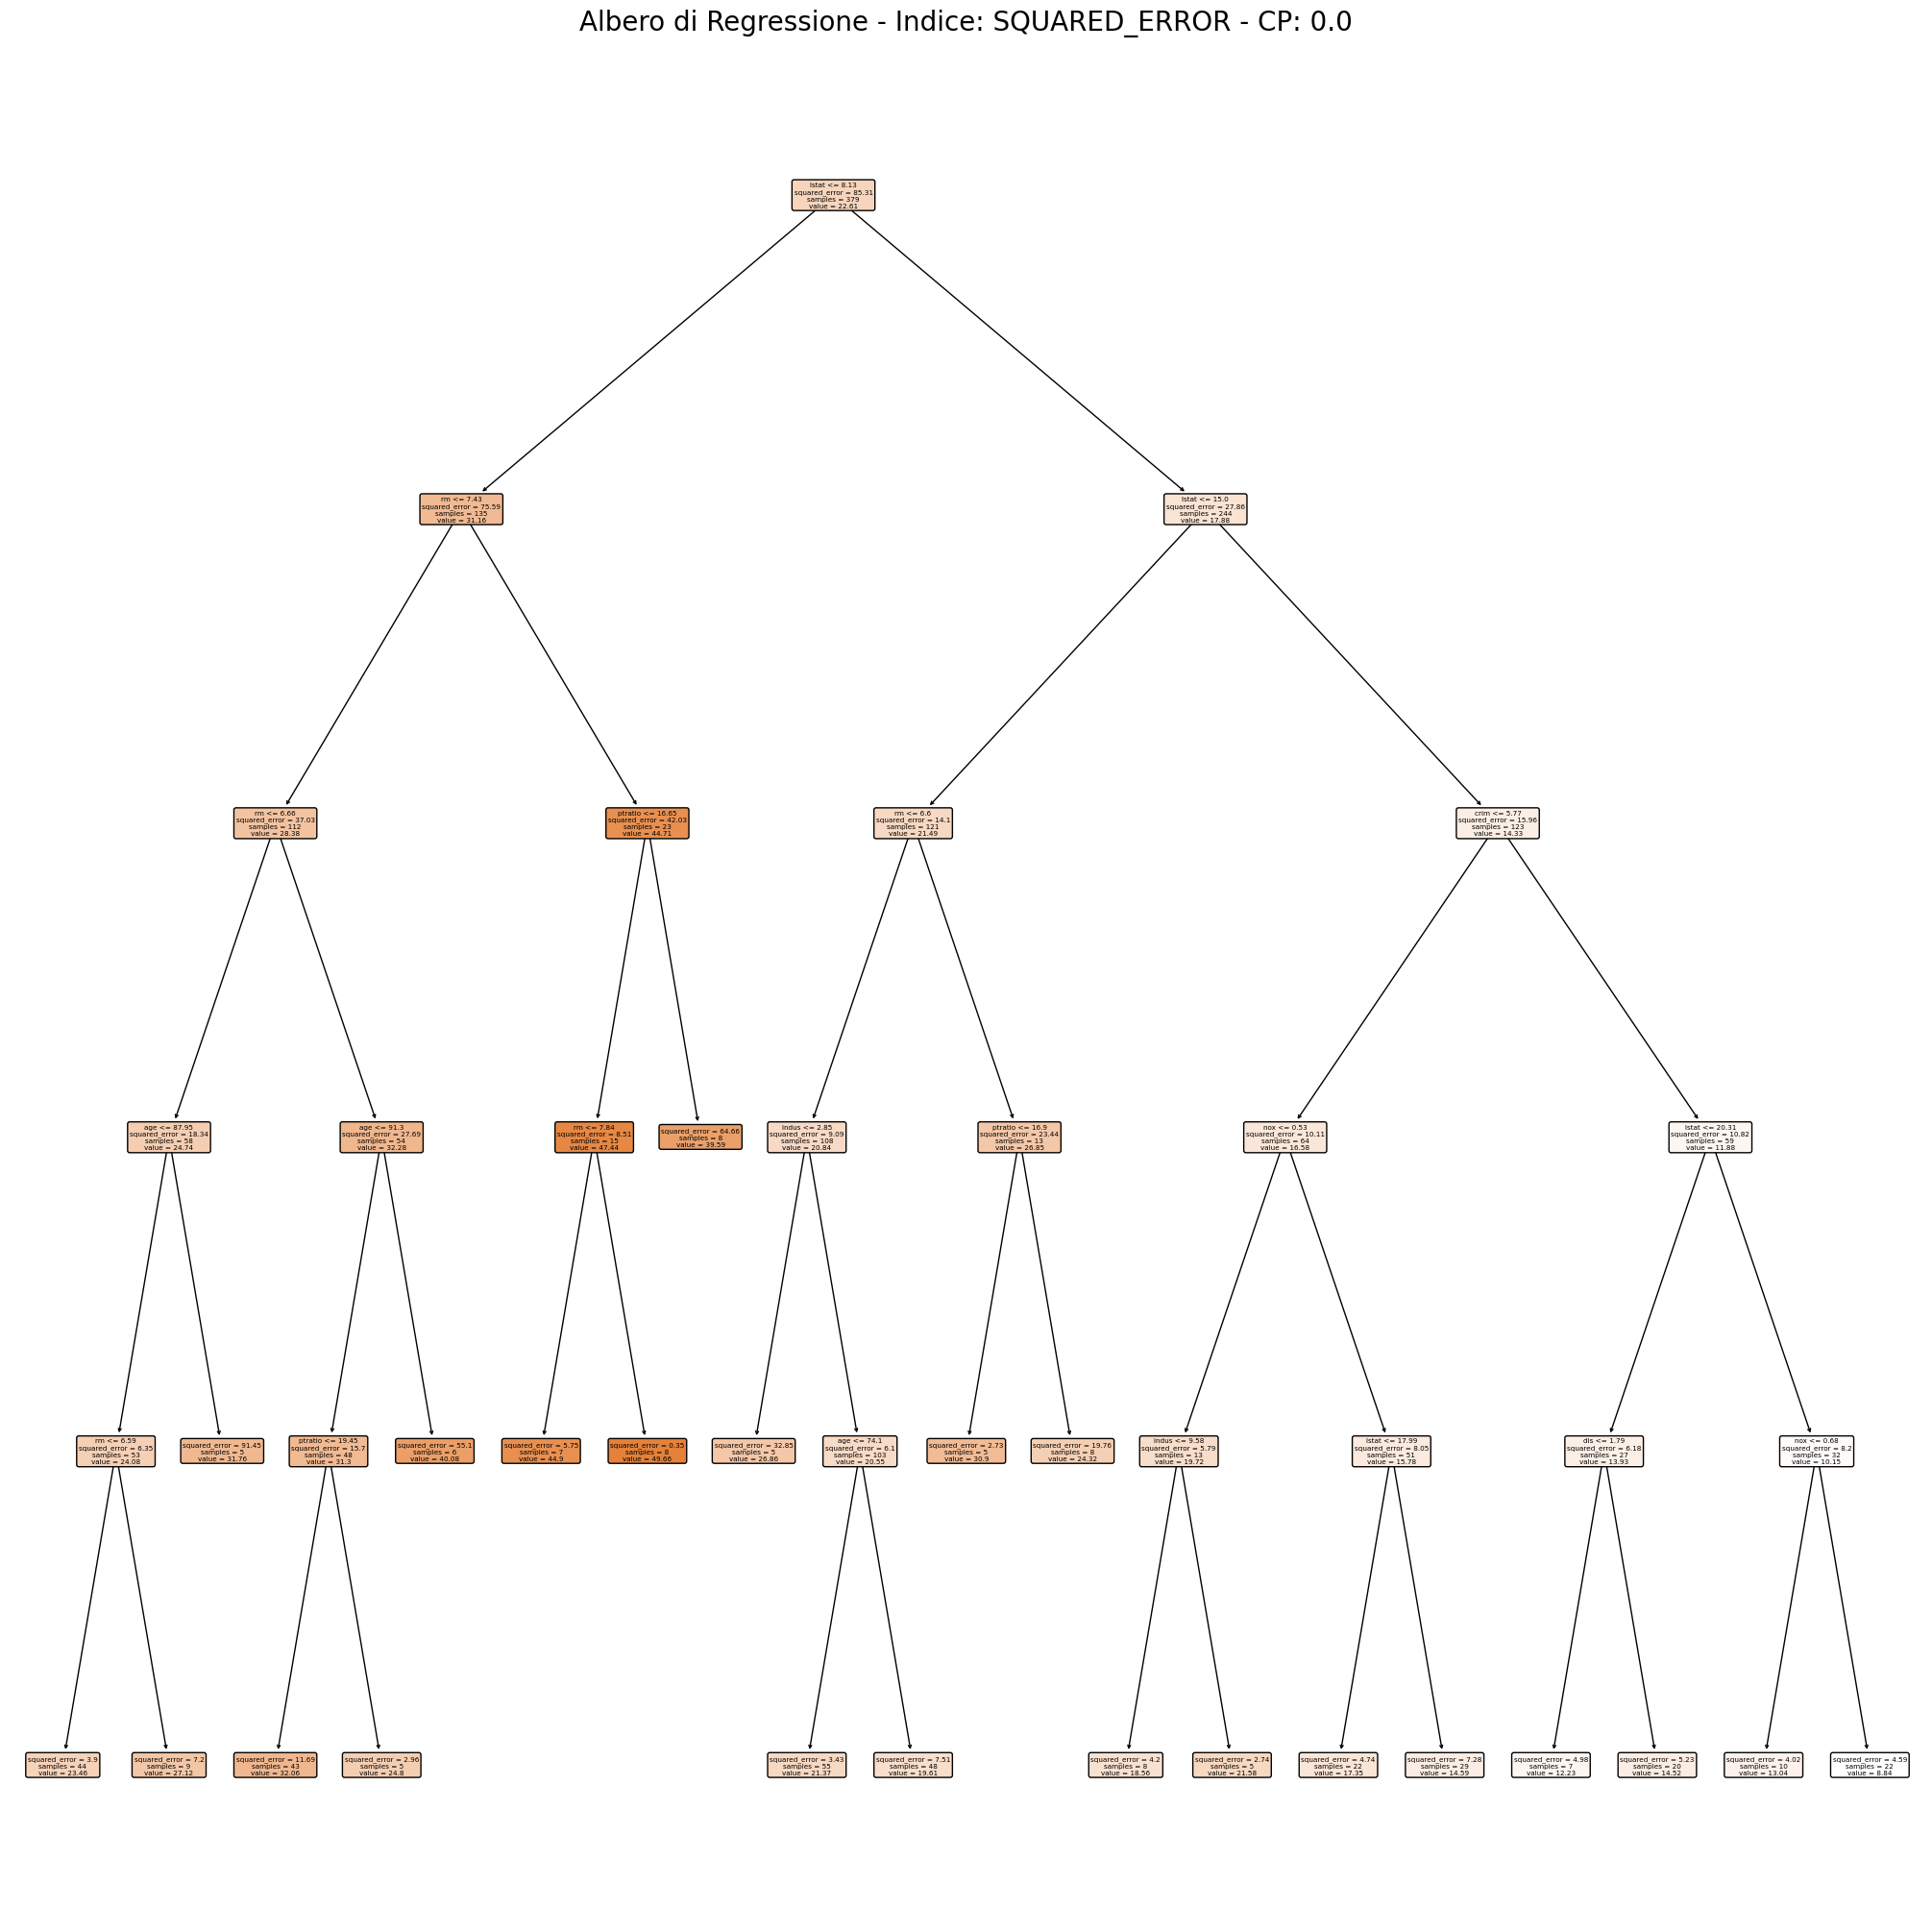

In [9]:
# Primo adattamento del modello ai dati
reg.auto_fit(X_train,y_train,
             verbose = 2,
             plot=True)

In [10]:
# Valori stimati dal modello
previsioni = reg.predict(X_test)
# Valutazione delle performance del modello
perf(y_test, 
     previsioni,
     plot=False)


REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  29.832
> RMSE: 5.462
> MAE:  3.228
> MAPE: 0.145


## Pruning

In [11]:
# Potatura automatica dell'albero di regressione
auto_pruned = reg.auto_prune(X_train, y_train,
                             auto=True,
                             plot=False,
                             n_splits=10,
                             print_path=False)
print(auto_pruned)

Il valore CP selezionato automaticamente è: 0.251

Tree of Regressione,                
> Leaf impurity criterion used: SQUARED_ERROR.                
> Maximum depth: 5.                    
> Min. number of samples required to split an internal node: 2.                    
> Min. number of samples required to be at a leaf node: 5.                        
> Seed used by the random number generator: 0.                        
> Max. number of leaves: None.                            
> A node will be split if this split induces a decrease of impurity greater than or equal to: 0.002.                            
> Complexity parameter used for pruning: 0.251 


In [12]:
# Adattamento dell'albero con valore di alpha selezionato in modo automatico
auto_pruned.auto_fit(X_train, y_train, verbose=1, plot=False)
# valori previsti
previsioni2 = auto_pruned.predict(X_test)
# valutazione della performance del modello potato automaticamente
perf(y_test, previsioni2)


FIT STATS:
---------------------------------
> Tree depth: 5
> Number of terminal nodes (leaves): 17
Time taken for fitting: 0.002 s

REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  28.777
> RMSE: 5.364
> MAE:  3.248
> MAPE: 0.148


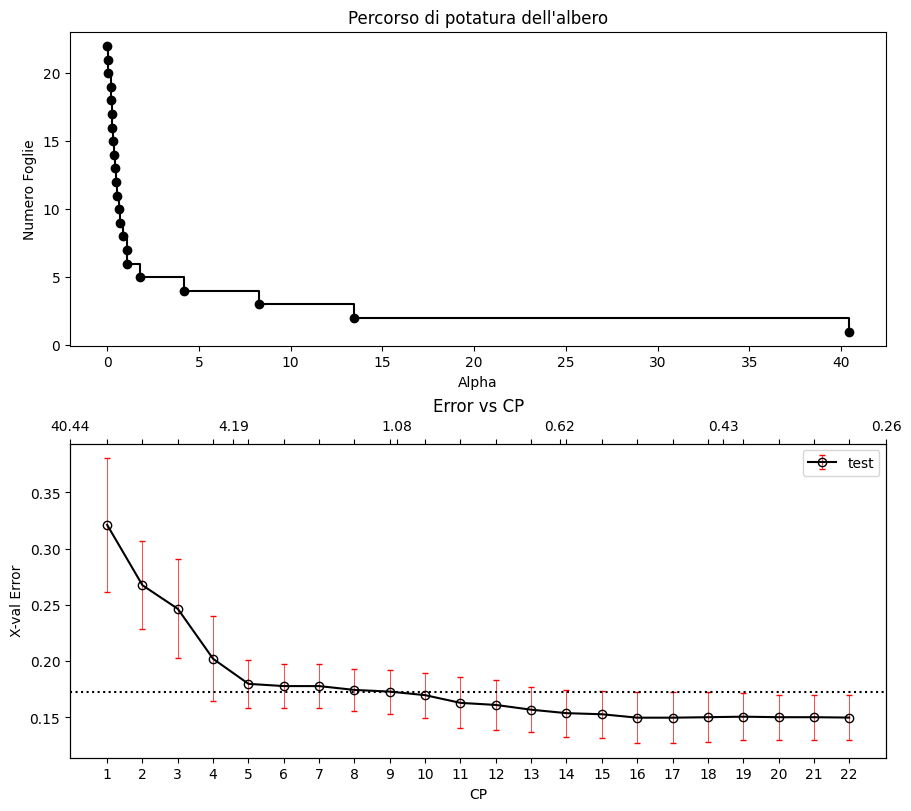


CROSS-VALIDATION RISULTS:
---------------------------------
   param_ccp_alpha  mean_test_score  std_test_score  rank_test_score  N_foglie
0              0.0         0.149905        0.020140                3        22
1         0.072149         0.150223        0.020020                5        21
2         0.073922         0.150223        0.020020                5        20
3         0.209106         0.150686        0.021070                7        19
4         0.223423         0.150221        0.022043                4        18
5         0.250672         0.149805        0.022898                1        17
6         0.264865         0.149805        0.022898                1        16
7         0.319848         0.152846        0.021036                8        15
8         0.350969         0.153816        0.020953                9        14
9         0.425315         0.156887        0.019980               10        13
10        0.500729         0.161113        0.021888               11  

In [13]:
# Potatura "manuale"
manually_pruned = reg.auto_prune(X_train, y_train,
                                 auto=False)


FIT STATS:
---------------------------------
> Tree depth: 5
> Number of terminal nodes (leaves): 11
Time taken for fitting: 0.003 s


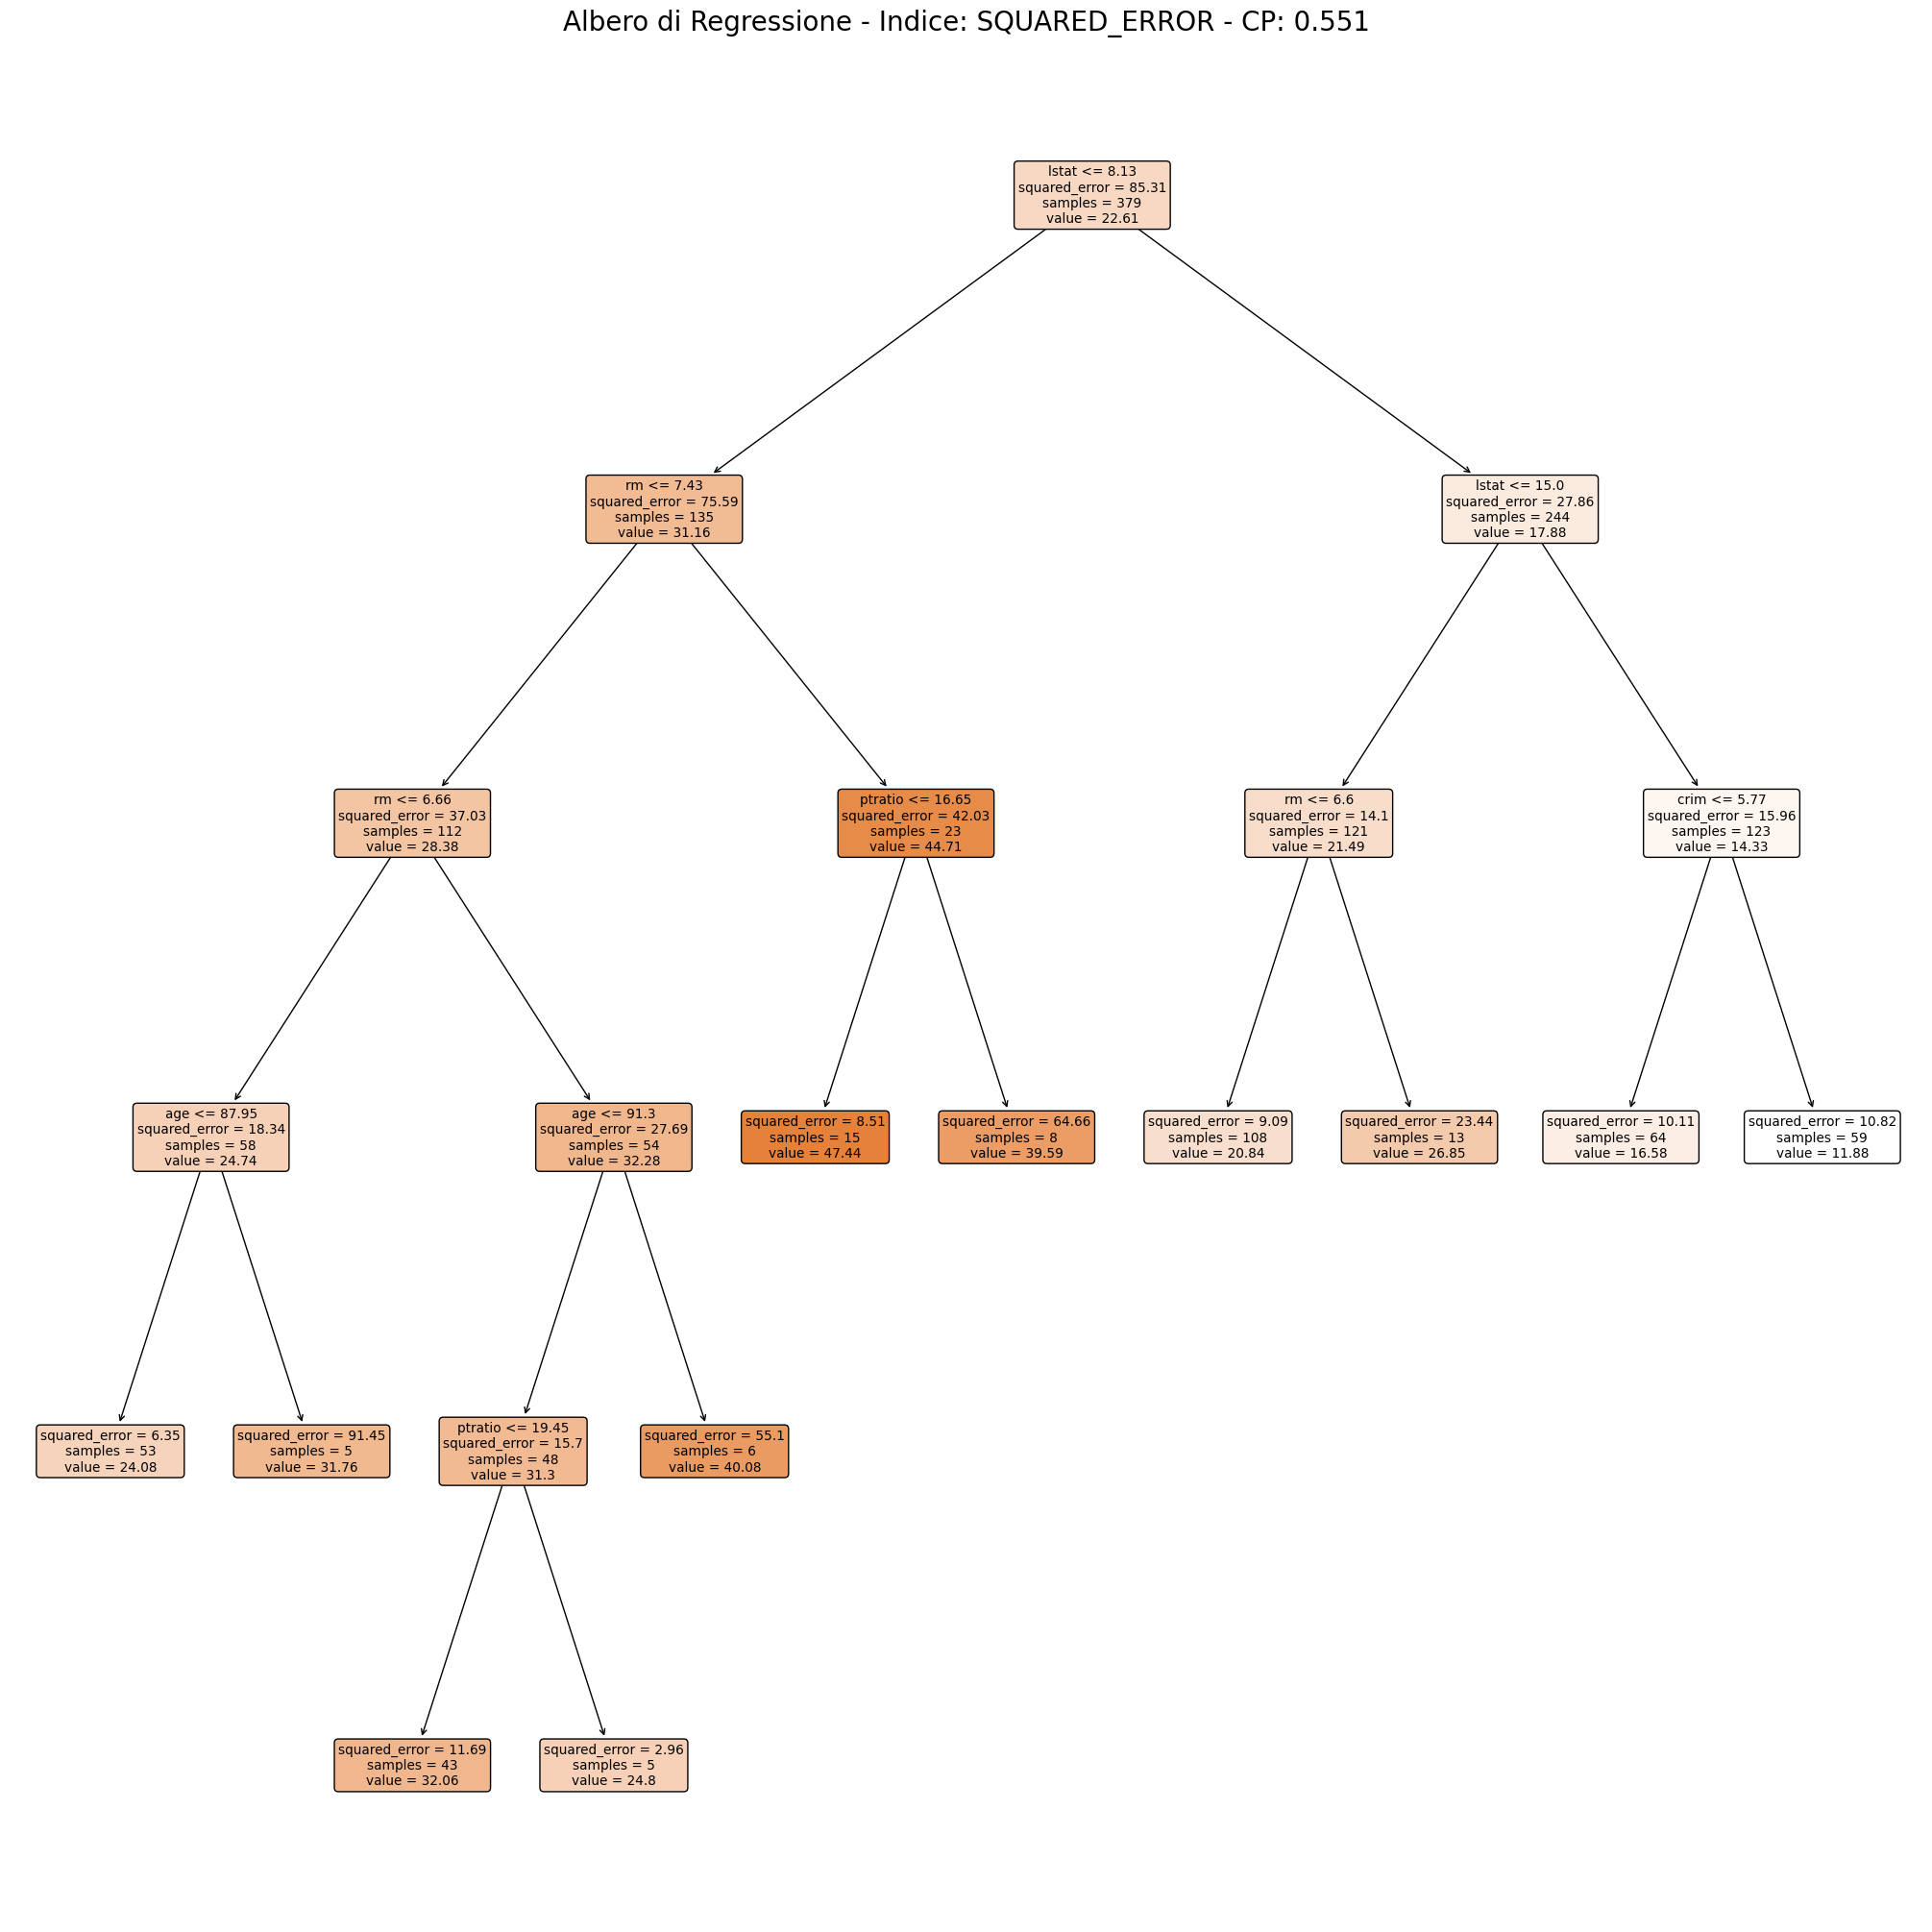


REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  28.481
> RMSE: 5.337
> MAE:  3.304
> MAPE: 0.159


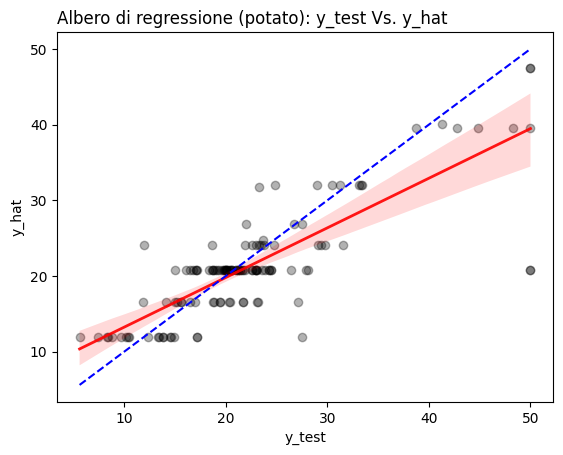

In [14]:
# Adattamento dell'albero potato manualmente
manually_pruned.auto_fit(X_train, y_train, 
                         verbose=1, 
                         plot=True)
# Previsione e valutazione delle performance
previsioni3 = manually_pruned.predict(X_test)
perf(y_test,previsioni3,
     plot=True,
     metodo="Albero di regressione (potato)")

## Ensemble

### Bagging

In [15]:
# inizializziamo l'ensemble con bagging
bag = AutoEnsemble(method = 'rf', n_estimators = 100, random_state = 0) # usiamo 'bagging' ma in realta il default e' 'rf'
# fit dei dati
bag.auto_fit(X_train, y_train)
# predizione + performance
bag_pred = bag.predict(X_test)

perf(y_test, bag_pred)


##### Ensemble method: Bootstrap aggregating! Successfully initialized! #####

 Tempo impiegato per l'addestramento: 0.101 secondi.

REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  17.046
> RMSE: 4.129
> MAE:  2.595
> MAPE: 0.118




########################################################
################ HYPER-PARAMETER TUNING ################
########################################################

Random search: 50 iterazioni per 10 combinazioni di parametri

La ricerca casuale ha impiegato: 6.76 secondi (circa) per 10 combinazioni di parametri

MODELLO SELEZIONATO TRAMITE CV:
Punteggio medio su insime di validazione: 11.850 (std: 5.723)
Parametri selezionati: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}


REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  16.449
> RMSE: 4.056
> MAE:  2.579
> MAPE: 0.118


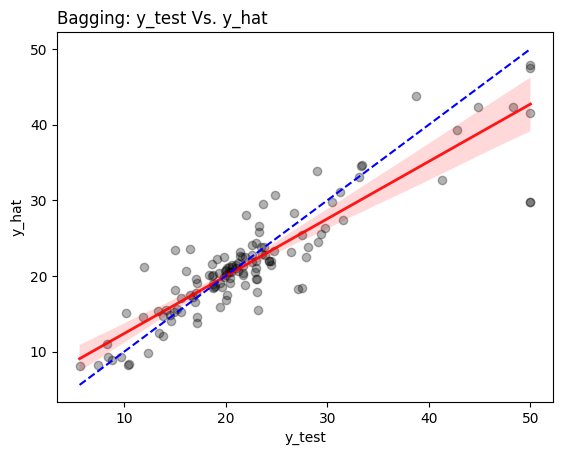

In [16]:
# tuning dei parametri : B non è un parametro fondamentale, basta scegliere un valore che non sia troppo piccolo
parametri = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 5,10,15,20],
        'min_samples_split': [1,2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

bag2 = bag.auto_tuning(
    X_train,
    y_train,
    parametri,
    n_splits=5,
    n_iter=10,
    randomized=True
)

# performance modello ottimizzato
bag_pred2 = bag2.predict(X_test)
perf(y_test, bag_pred2,metodo='Bagging',plot=True)

#### Feature Selection

Threshold: 0.017604159921605536
N. di feature selezionate: 6
Feature selezionate: ['crim', 'rm', 'dis', 'tax', 'ptratio', 'lstat']


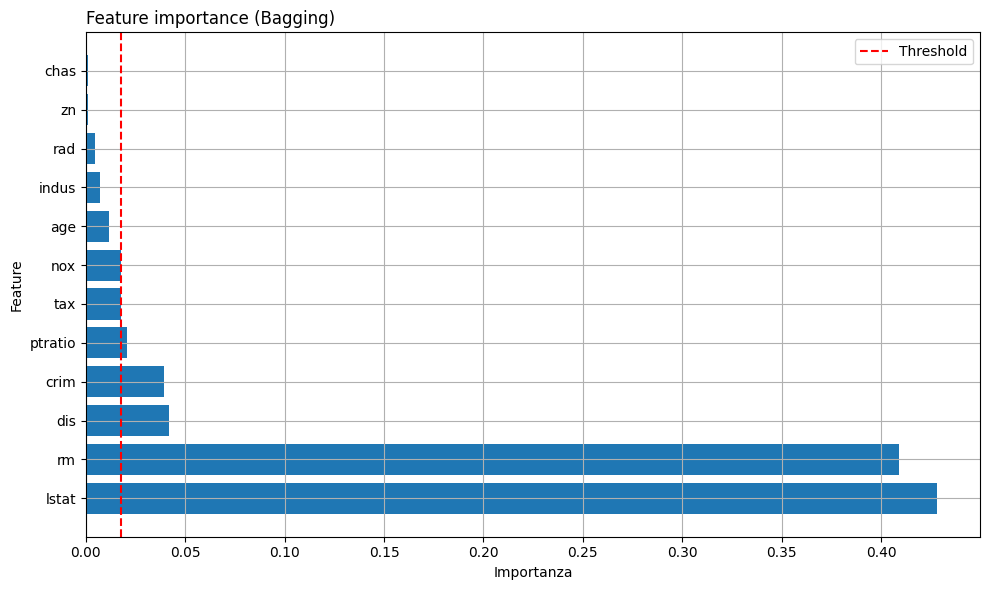

['crim', 'rm', 'dis', 'tax', 'ptratio', 'lstat']

In [17]:
# feature selection del modello bagging
bag2.auto_features(X_train,
                   threshold='median',
                   plot=True)

### Random Forest

In [18]:
# inizializzazione con RF con i predittori selezionati 
rf = AutoEnsemble(max_features=6) # m=6
# adattamento ai dati di training
rf.auto_fit(X_train, y_train)
# predict + performance
rf_pred = rf.predict(X_test)
perf(y_test, rf_pred)


##### Ensemble method: Random Forest! Successfully initialized! #####

 Tempo impiegato per l'addestramento: 0.079 secondi.

REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  21.003
> RMSE: 4.583
> MAE:  2.665
> MAPE: 0.119


In [19]:
# tuning 
parametri_rf = {'n_estimators': [200,500,1000],
                'criterion':['squared_error','friedman_mse'],
                'max_features': [None,6,'sqrt','log2']}

rf2 = rf.auto_tuning(X_train,y_train,
                     parametri_rf,
                     n_splits=5,
                     n_iter=10,
                     random_state=0)



########################################################
################ HYPER-PARAMETER TUNING ################
########################################################

Random search: 50 iterazioni per 10 combinazioni di parametri

La ricerca casuale ha impiegato: 6.60 secondi (circa) per 10 combinazioni di parametri

MODELLO SELEZIONATO TRAMITE CV:
Punteggio medio su insime di validazione: 9.517 (std: 4.763)
Parametri selezionati: {'n_estimators': 1000, 'max_features': 'log2', 'criterion': 'friedman_mse'}




REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  20.665
> RMSE: 4.546
> MAE:  2.657
> MAPE: 0.119


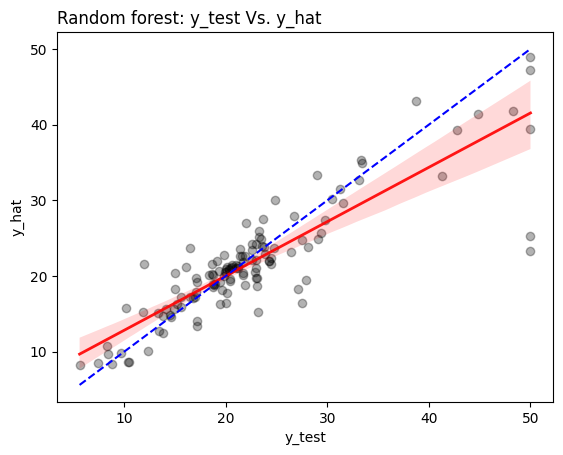

In [20]:
# Performance del modello ottimizzato
rf_pred2 = rf2.predict(X_test)
perf(y_test, rf_pred2,metodo='Random Forest',plot=True)

Threshold: 0.04114427470269267
N. di feature selezionate: 6
Feature selezionate: ['crim', 'indus', 'rm', 'dis', 'ptratio', 'lstat']


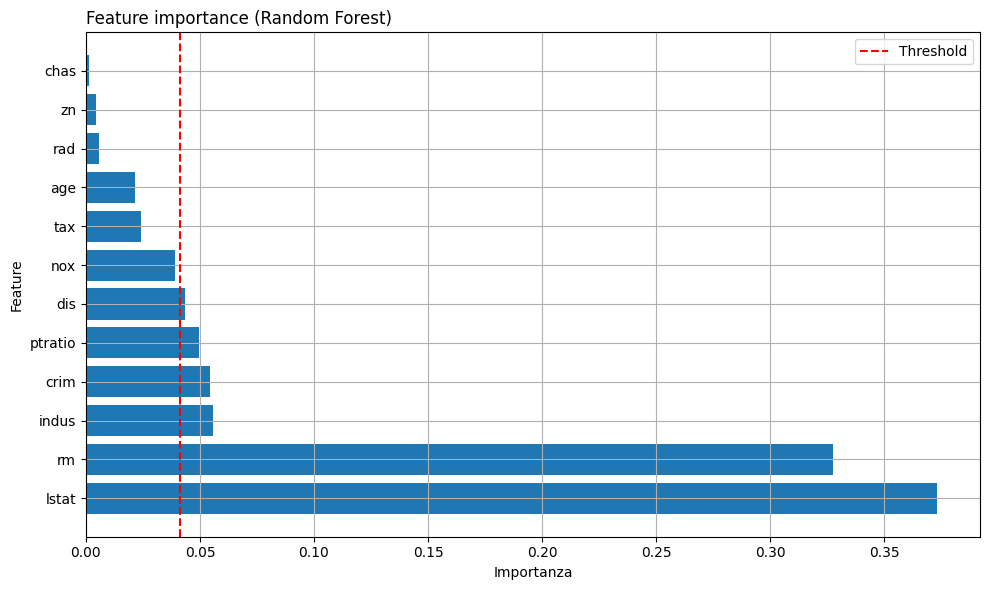

['crim', 'indus', 'rm', 'dis', 'ptratio', 'lstat']

In [21]:
# Importanza dei predittori (Random Forest)
rf2.auto_features(X_train)

### Boosting

In [22]:
# Inizializzazione
boost = AutoEnsemble('gb')
# adattamento
boost.auto_fit(X_train, y_train)
# previsione
y_pred = boost.predict(X_test)
# performance
perf(y_test, y_pred)



##### Ensemble method: Boosting! Successfully initialized! #####

 Tempo impiegato per l'addestramento: 0.189 secondi.

REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  71.143
> RMSE: 8.435
> MAE:  5.824
> MAPE: 0.314




########################################################
################ HYPER-PARAMETER TUNING ################
########################################################

Random search: 50 iterazioni per 10 combinazioni di parametri

La ricerca casuale ha impiegato: 8.10 secondi (circa) per 10 combinazioni di parametri

MODELLO SELEZIONATO TRAMITE CV:
Punteggio medio su insime di validazione: 8.798 (std: 3.457)
Parametri selezionati: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


REGRESSION PERFORMANCE:
----------------------------------------
> MSE:  13.589
> RMSE: 3.686
> MAE:  2.416
> MAPE: 0.114


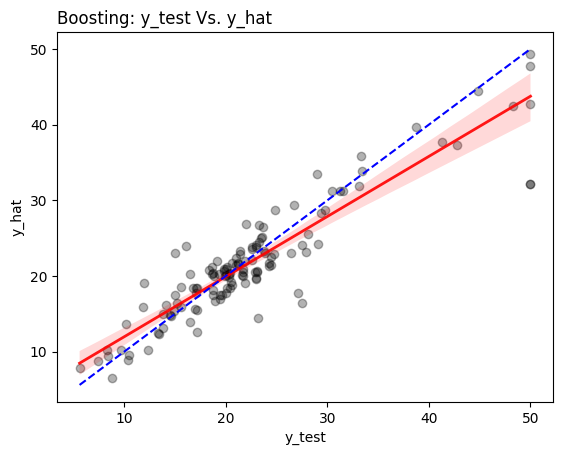

In [23]:
# tuning
parametri ={
    'max_depth': [1,2,3],
    'n_estimators': [500, 1000, 5000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1,0.2],
    'criterion': ['friedman_mse', 'squared_error']
}

boost2 = boost.auto_tuning(X_train, y_train, 
                           parametri,
                           n_splits=5, 
                           n_iter=10,
                           random_state=0)

pred2 = boost2.predict(X_test)
perf(y_test,pred2,plot=True,metodo='Boosting')

## Confronto fra metodi

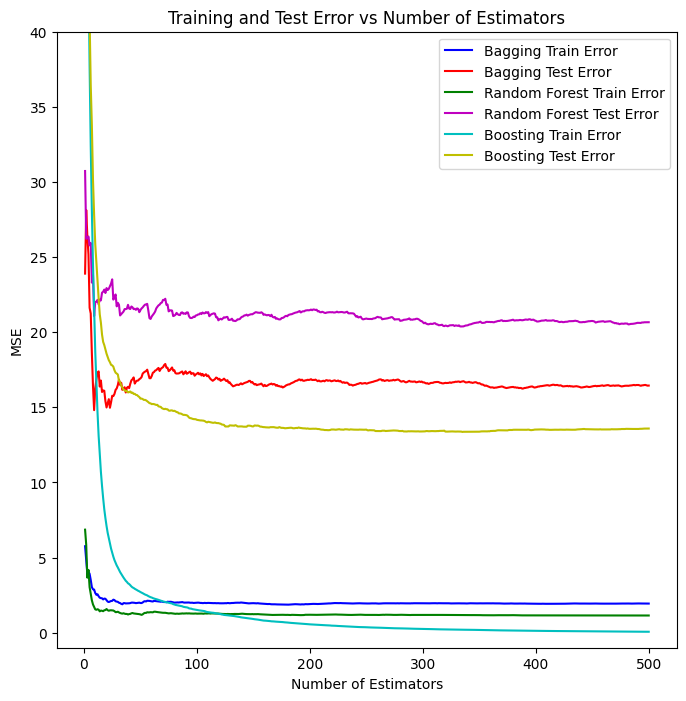

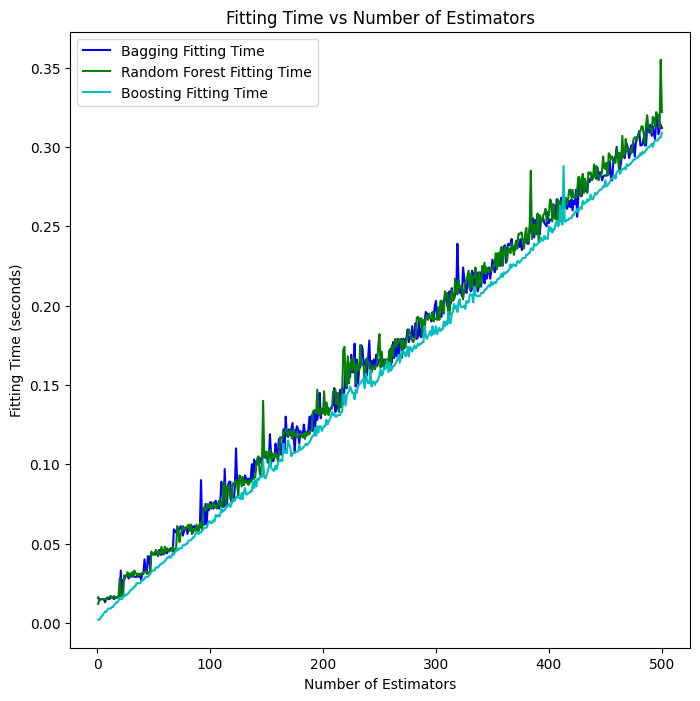

Time:  5  ~minutes


In [24]:
# confronto tra i metodi 
method_comparison(X_train,
                  X_test,
                  y_train,
                  y_test,{'bagging':bag2,"rf":rf2,"boosting":boost2},
                  train=True,
                  max_estimators=500)